In [3]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- FIX: Define the correct column names manually ---
# These are the actual column names from the NYC Open Data website
column_names = [
    'school_year', 'busbreakdown_id', 'run_type', 'bus_no', 'route_number',
    'reason', 'schools_serviced', 'occurred_on', 'created_on', 'boro',
    'bus_company_name', 'how_long_delayed', 'number_of_students_on_bus',
    'has_contractor_notified_schools', 'has_contractor_notified_parents',
    'have_parents_been_notified', 'informed_on', 'incident_id',
    'last_updated_on', 'breakdown_or_running_late', 'school_age_or_prek'
]

# Load the dataset, skipping the incorrect header row and applying our correct names
df = pd.read_csv("Bus_Breakdown_and_Delays_20251008.csv", header=0, names=column_names)

# Display the first few rows and basic info to confirm the fix
print("Dataset Head (Corrected):")
print(df.head())
print("\nDataset Info (Corrected):")
df.info()

C:\Users\krish\AppData\Local\Temp\ipykernel_12000\1298982464.py:23: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Bus_Breakdown_and_Delays_20251008.csv", header=0, names=column_names)


Dataset Head (Corrected):
  school_year  busbreakdown_id           run_type bus_no route_number  \
0   2023-2024          1843913  Special Ed AM Run   6133         Q866   
1   2023-2024          1843914  Special Ed AM Run  18643         K252   
2   2023-2024          1843915  General Ed AM Run    358        Q2424   
3   2023-2024          1843916  Special Ed AM Run   5849         X104   
4   2023-2024          1843917  Special Ed AM Run  41801         K083   

               reason         schools_serviced             occurred_on  \
0       Heavy Traffic                    28402  09/22/2023 06:15:00 AM   
1  Mechanical Problem  22060,22206,22234,22255  09/22/2023 06:42:00 AM   
2  Mechanical Problem              24025,24153  09/22/2023 06:30:00 AM   
3       Heavy Traffic                    08022  09/22/2023 06:45:00 AM   
4       Heavy Traffic  19020,19218,19460,19935  09/22/2023 06:45:00 AM   

               created_on      boro  ... how_long_delayed  \
0  09/22/2023 06:45:00 AM    

In [4]:
# --- Step 1: Clean up column names for easier access ---
df.columns = df.columns.str.replace(' ', '_').str.lower()

# --- Step 2: Convert 'occurred_on' to datetime objects ---
df['occurred_on'] = pd.to_datetime(df['occurred_on'])

# --- Step 3: Handle missing values ---
# For this project, we'll drop rows where key information is missing
critical_cols = ['boro', 'how_long_delayed', 'reason', 'bus_company_name']
df.dropna(subset=critical_cols, inplace=True)

# --- Step 4: Parse the 'how_long_delayed' text column into minutes ---
def parse_delay_time(delay_str):
    if pd.isna(delay_str):
        return None
    delay_str = str(delay_str).lower()
    total_minutes = 0
    
    # Handle ranges like '30-45min' by taking the average
    if '-' in delay_str:
        parts = delay_str.split('-')
        try:
            # Assumes format is 'num1-num2 unit'
            low = int(parts[0].strip())
            high_part = parts[1].strip().split()[0]
            high = int(high_part)
            avg_minutes = (low + high) / 2
            return avg_minutes
        except:
            return None

    # Handle hours and minutes
    if 'hour' in delay_str:
        # Find number before 'hour'
        try:
            hours = int(delay_str.split('hour')[0].strip().split()[-1])
            total_minutes += hours * 60
        except:
            pass # No integer found
            
    if 'min' in delay_str or 'mn' in delay_str:
        # Find number before 'min' or 'mn'
        try:
            mins = int(delay_str.split('min')[0].strip().split()[-1])
            total_minutes += mins
        except:
            pass # No integer found
            
    return total_minutes if total_minutes > 0 else None

# Apply the function to create a new numerical column
df['delay_minutes'] = df['how_long_delayed'].apply(parse_delay_time)

# Drop rows where parsing failed
df.dropna(subset=['delay_minutes'], inplace=True)


# --- Step 5: Feature Engineering from the datetime column ---
df['hour'] = df['occurred_on'].dt.hour
df['day_of_week'] = df['occurred_on'].dt.dayofweek # Monday=0, Sunday=6
df['day_name'] = df['occurred_on'].dt.day_name()
df['month'] = df['occurred_on'].dt.month

# --- Step 6: Create a 'Delay Severity' category ---
# This will be our target for the ML model
bins = [0, 15, 45, np.inf] # 0-15 min, 16-45 min, >45 min
labels = ['Minor', 'Moderate', 'Severe']
df['delay_severity'] = pd.cut(df['delay_minutes'], bins=bins, labels=labels, right=True)

# --- Final Check ---
print("\nCleaned Data Head:")
print(df[['occurred_on', 'how_long_delayed', 'delay_minutes', 'delay_severity', 'hour', 'day_name']].head())
print(f"\nShape of cleaned data: {df.shape}")


Cleaned Data Head:
          occurred_on how_long_delayed  delay_minutes delay_severity  hour  \
0 2023-09-22 06:15:00        61-90 Min           75.5         Severe     6   
1 2023-09-22 06:42:00        16-30 Min           23.0       Moderate     6   
3 2023-09-22 06:45:00        16-30 Min           23.0       Moderate     6   
4 2023-09-22 06:45:00        16-30 Min           23.0       Moderate     6   
5 2023-09-22 06:45:00        46-60 Min           53.0         Severe     6   

  day_name  
0   Friday  
1   Friday  
3   Friday  
4   Friday  
5   Friday  

Shape of cleaned data: (148707, 27)


In [5]:
# --- Step 1: Standardize column names (optional but good practice) ---
# The corrected loading step already gave us good names, so we can skip this
# df.columns = df.columns.str.replace(' ', '_').str.lower()

# --- Step 2: Convert date/time columns to datetime objects ---
df['occurred_on'] = pd.to_datetime(df['occurred_on'])

# --- Step 3: Handle missing values in key columns ---
# Drop rows where essential information for our analysis is missing
critical_cols = ['boro', 'how_long_delayed', 'reason', 'bus_company_name']
df.dropna(subset=critical_cols, inplace=True)

# --- Step 4: Parse the 'how_long_delayed' column into a number (minutes) ---
# This function handles text like "16-30 Min" by taking the average (23)
def parse_delay_time(delay_str):
    delay_str = str(delay_str).lower()
    if '-' in delay_str:
        try:
            parts = delay_str.split('-')
            low = int(parts[0].strip())
            high = int(parts[1].split(' ')[0].strip())
            return (low + high) / 2
        except:
            return None # Return None if parsing fails
    elif 'min' in delay_str:
        try:
            return int(delay_str.split(' ')[0])
        except:
            return None
    return None

df['delay_minutes'] = df['how_long_delayed'].apply(parse_delay_time)
df.dropna(subset=['delay_minutes'], inplace=True) # Drop rows where parsing failed

# --- Step 5: Engineer new features from the 'occurred_on' date ---
df['hour'] = df['occurred_on'].dt.hour
df['day_of_week'] = df['occurred_on'].dt.day_name()
df['month'] = df['occurred_on'].dt.month

# --- Step 6: Create a 'Delay Severity' category for our ML model ---
bins = [0, 15, 45, np.inf] # Bins: 0-15 (Minor), 16-45 (Moderate), >45 (Severe)
labels = ['Minor', 'Moderate', 'Severe']
df['delay_severity'] = pd.cut(df['delay_minutes'], bins=bins, labels=labels, right=False)

# --- Final Check of the Cleaned Data ---
print("Cleaned and Engineered Data Head:")
print(df[['occurred_on', 'delay_minutes', 'delay_severity', 'hour', 'day_of_week']].head())
print(f"\nShape of cleaned data: {df.shape}")

Cleaned and Engineered Data Head:
          occurred_on  delay_minutes delay_severity  hour day_of_week
0 2023-09-22 06:15:00           75.5         Severe     6      Friday
1 2023-09-22 06:42:00           23.0       Moderate     6      Friday
3 2023-09-22 06:45:00           23.0       Moderate     6      Friday
4 2023-09-22 06:45:00           23.0       Moderate     6      Friday
5 2023-09-22 06:45:00           53.0         Severe     6      Friday

Shape of cleaned data: (148707, 27)


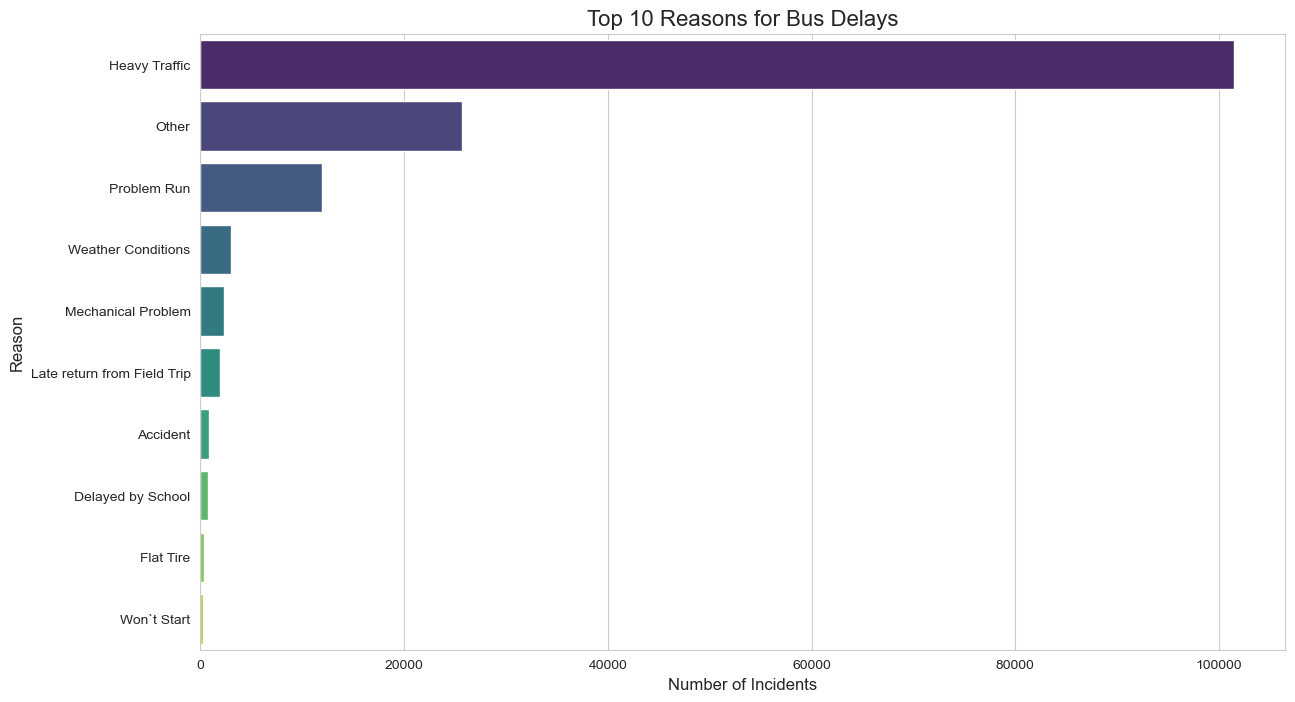

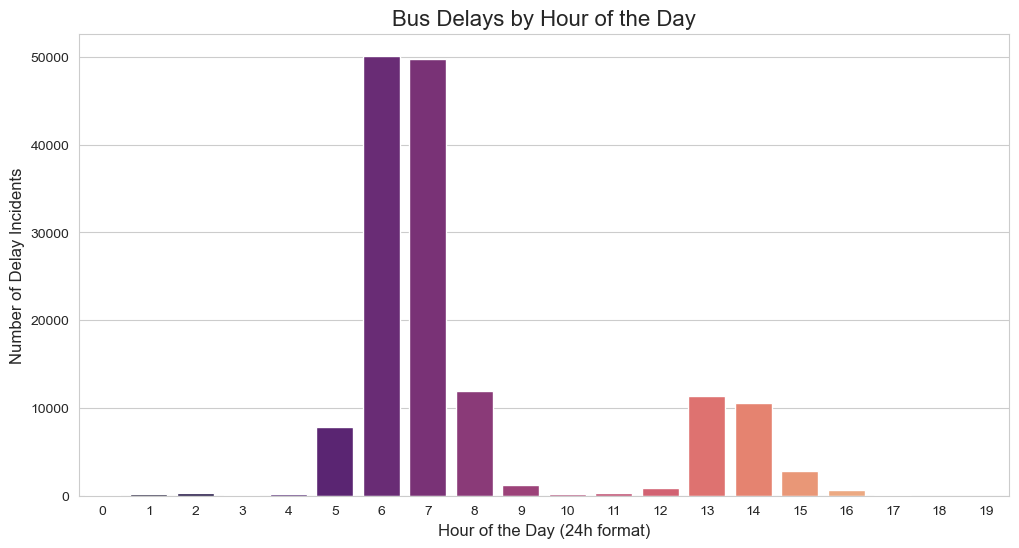

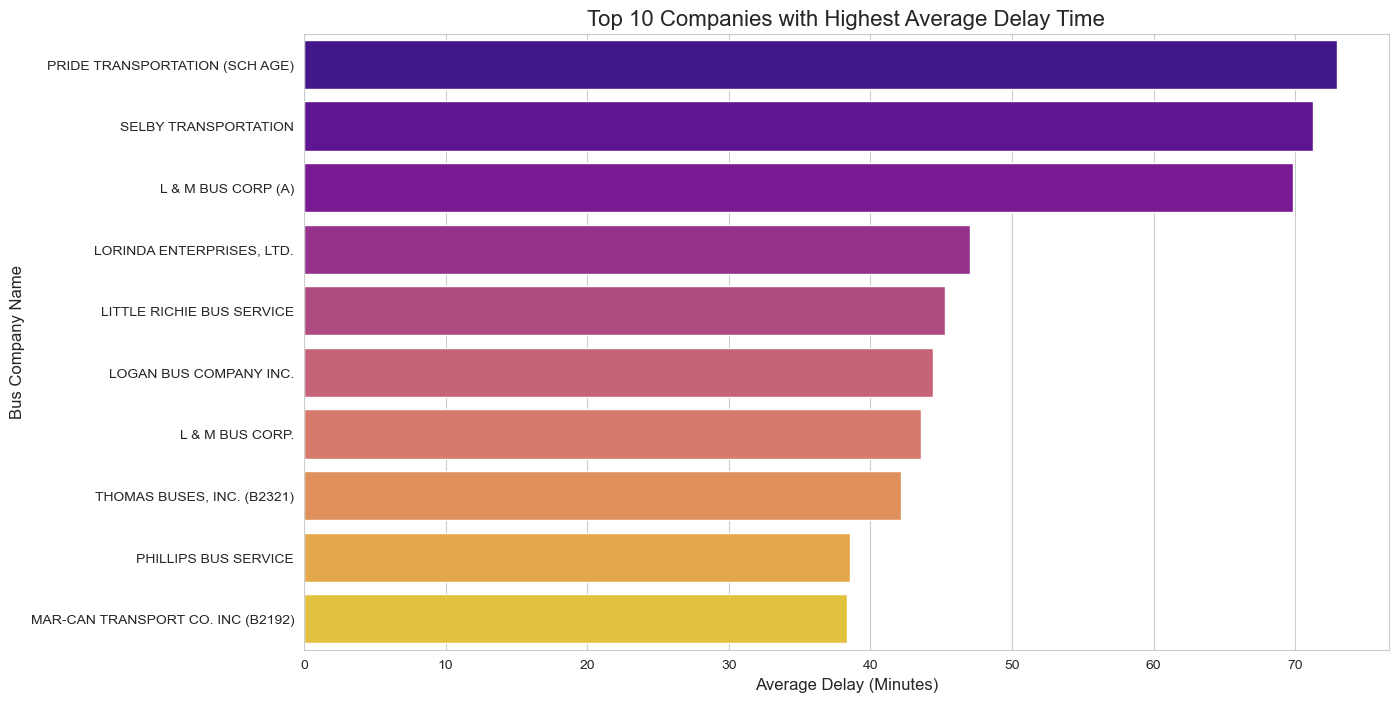

In [6]:
# --- 1. What are the biggest causes of delays? ---
plt.figure(figsize=(14, 8))
sns.countplot(y=df['reason'], order=df['reason'].value_counts().iloc[:10].index, palette='viridis')
plt.title('Top 10 Reasons for Bus Delays', fontsize=16)
plt.xlabel('Number of Incidents', fontsize=12)
plt.ylabel('Reason', fontsize=12)
plt.show()

# --- 2. When do delays happen most often? (By Hour) ---
plt.figure(figsize=(12, 6))
sns.countplot(x=df['hour'], palette='magma')
plt.title('Bus Delays by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24h format)', fontsize=12)
plt.ylabel('Number of Delay Incidents', fontsize=12)
plt.show()

# --- 3. Which bus companies are the least reliable? ---
# Calculate average delay time for companies with a significant number of incidents (e.g., > 500)
company_counts = df['bus_company_name'].value_counts()
frequent_companies = company_counts[company_counts > 500].index
company_avg_delay = df[df['bus_company_name'].isin(frequent_companies)].groupby('bus_company_name')['delay_minutes'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
sns.barplot(y=company_avg_delay.index, x=company_avg_delay.values, palette='plasma')
plt.title('Top 10 Companies with Highest Average Delay Time', fontsize=16)
plt.xlabel('Average Delay (Minutes)', fontsize=12)
plt.ylabel('Bus Company Name', fontsize=12)
plt.show()


Training the RandomForestClassifier model...
Model training complete.

Evaluating model performance...
Model Accuracy: 79.71%

Classification Report:
              precision    recall  f1-score   support

       Minor       0.53      0.82      0.64      5261
    Moderate       0.86      0.77      0.81     23815
      Severe       0.86      0.84      0.85     15535

    accuracy                           0.80     44611
   macro avg       0.75      0.81      0.77     44611
weighted avg       0.82      0.80      0.80     44611



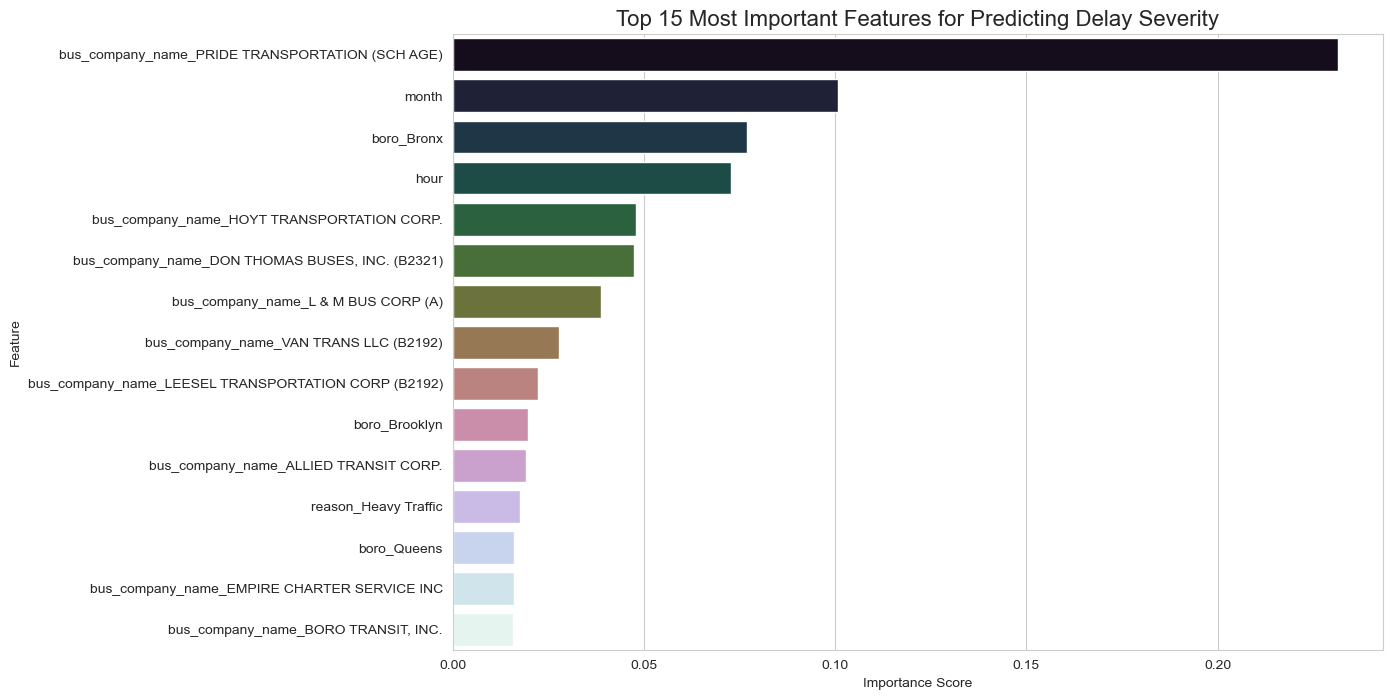

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# --- 1. Prepare the data for the model ---
# Drop rows where our target variable is null
model_df = df.dropna(subset=['delay_severity', 'boro', 'reason', 'run_type', 'bus_company_name'])

# Select features (X) and the target (y)
features = ['boro', 'reason', 'run_type', 'bus_company_name', 'hour', 'month']
target = 'delay_severity'

X = model_df[features]
y = model_df[target]

# --- 2. Preprocessing: Convert all text columns into numbers ---
# One-Hot Encoding handles categorical variables without implying an order
X_encoded = pd.get_dummies(X, columns=['boro', 'reason', 'run_type', 'bus_company_name'])

# --- 3. Split data into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, stratify=y)

# --- 4. Train a Random Forest Classifier ---
print("\nTraining the RandomForestClassifier model...")
# Using class_weight='balanced' helps the model learn from less frequent classes (like 'Severe')
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)
print("Model training complete.")

# --- 5. Evaluate the model's performance ---
print("\nEvaluating model performance...")
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2%}")

# The classification report gives a detailed breakdown of performance for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 6. Identify the most important features ---
# This tells us what factors the model uses most to make its predictions
feature_importances = pd.Series(model.feature_importances_, index=X_encoded.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='cubehelix')
plt.title('Top 15 Most Important Features for Predicting Delay Severity', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [9]:
# Import the necessary tool
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# --- Step 1: Define the parameter grid to search ---
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False]
}

# --- Step 2: Set up the Randomized Search ---
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# We use n_jobs=1 to prevent memory errors. This will be slower but reliable.
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1  # <-- THE FIX IS HERE
)

# --- Step 3: Run the search to find the best model ---
print("Starting hyperparameter tuning...")
random_search.fit(X_train, y_train)
print("Tuning complete.")

# --- Step 4: Evaluate the new, optimized model ---
print("\nBest parameters found:")
print(random_search.best_params_)

best_model = random_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
new_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"\nAccuracy of Tuned Model: {new_accuracy:.2%}")
print("\nClassification Report for Tuned Model:")
print(classification_report(y_test, y_pred_tuned))

Starting hyperparameter tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=  17.6s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=  18.2s
[CV] END bootstrap=True, max_depth=38, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=  17.9s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=187; total time=  20.9s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=187; total time=  21.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=7, min_samples_split=12, n_estimators=187; total time=  21.1s
[CV] END bootstrap=True, max_depth=45, min_samples_leaf=8, min_samples_split=4, n_estimators=249; total time=  27.6s
[CV] END bootstrap=True, max_depth=45, min_samples_leaf=8, min_samples_split

Estimated cost calculated for each incident:
               reason  delay_minutes delay_severity  estimated_cost
0       Heavy Traffic           75.5         Severe          193.75
1  Mechanical Problem           23.0       Moderate           62.50
3       Heavy Traffic           23.0       Moderate           62.50
4       Heavy Traffic           23.0       Moderate           62.50
5               Other           53.0         Severe          137.50


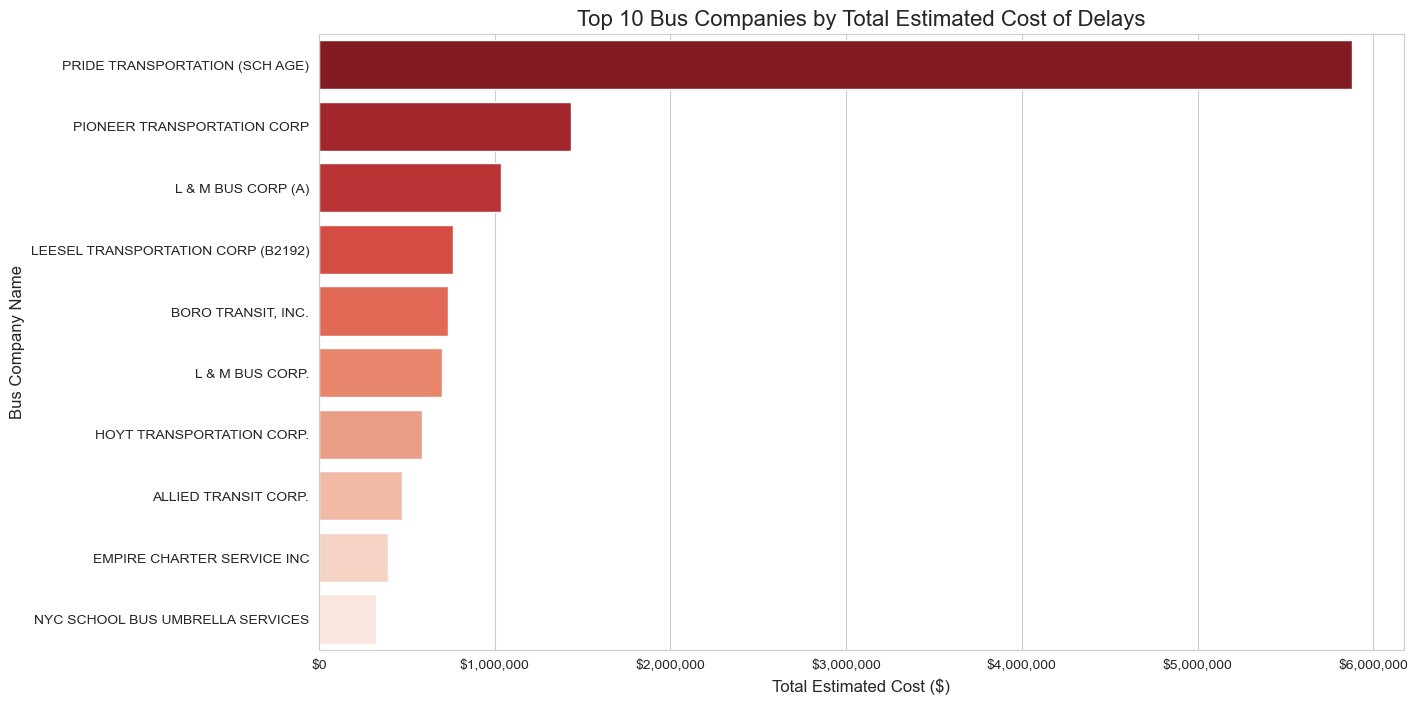

In [10]:
# --- Step 1: Define cost assumptions ---
# These are hypothetical costs to demonstrate the method
cost_assumptions = {
    'cost_per_minute_late': 2.50,  # Represents fuel, driver/staff overtime, etc.
    'parent_communication_cost': 5.00, # Fixed cost per incident for communication overhead
    'replacement_bus_dispatch': 500.00 # High cost for severe mechanical failures
}

# --- Step 2: Create a function to calculate the cost of each incident ---
def calculate_incident_cost(row):
    # Base cost is delay time + communication
    total_cost = (row['delay_minutes'] * cost_assumptions['cost_per_minute_late']) + \
                 cost_assumptions['parent_communication_cost']
    
    # Add a large fixed cost for severe mechanical breakdowns requiring a new bus
    if row['reason'] == 'Mechanical Problem' and row['delay_severity'] == 'Severe':
        total_cost += cost_assumptions['replacement_bus_dispatch']
        
    return total_cost

# --- Step 3: Apply the cost function to the entire dataset ---
# We'll use our original cleaned dataframe 'df' for this
df['estimated_cost'] = df.apply(calculate_incident_cost, axis=1)

print("Estimated cost calculated for each incident:")
print(df[['reason', 'delay_minutes', 'delay_severity', 'estimated_cost']].head())

# --- Step 4: Aggregate costs to find the most "expensive" companies ---
company_costs = df.groupby('bus_company_name')['estimated_cost'].sum().sort_values(ascending=False)

# --- Step 5: Visualize the financial impact ---
plt.figure(figsize=(14, 8))
top_10_costly_companies = company_costs.head(10)
sns.barplot(x=top_10_costly_companies.values, y=top_10_costly_companies.index, palette='Reds_r')
plt.title('Top 10 Bus Companies by Total Estimated Cost of Delays', fontsize=16)
plt.xlabel('Total Estimated Cost ($)', fontsize=12)
plt.ylabel('Bus Company Name', fontsize=12)
# Format the x-axis to look like currency
plt.gca().xaxis.set_major_formatter('${x:,.0f}')
plt.show()

Sample of Estimated Costs per Incident:
               reason  delay_minutes delay_severity  estimated_cost
0       Heavy Traffic           75.5         Severe          193.75
1  Mechanical Problem           23.0       Moderate           62.50
3       Heavy Traffic           23.0       Moderate           62.50
4       Heavy Traffic           23.0       Moderate           62.50
5               Other           53.0         Severe          137.50


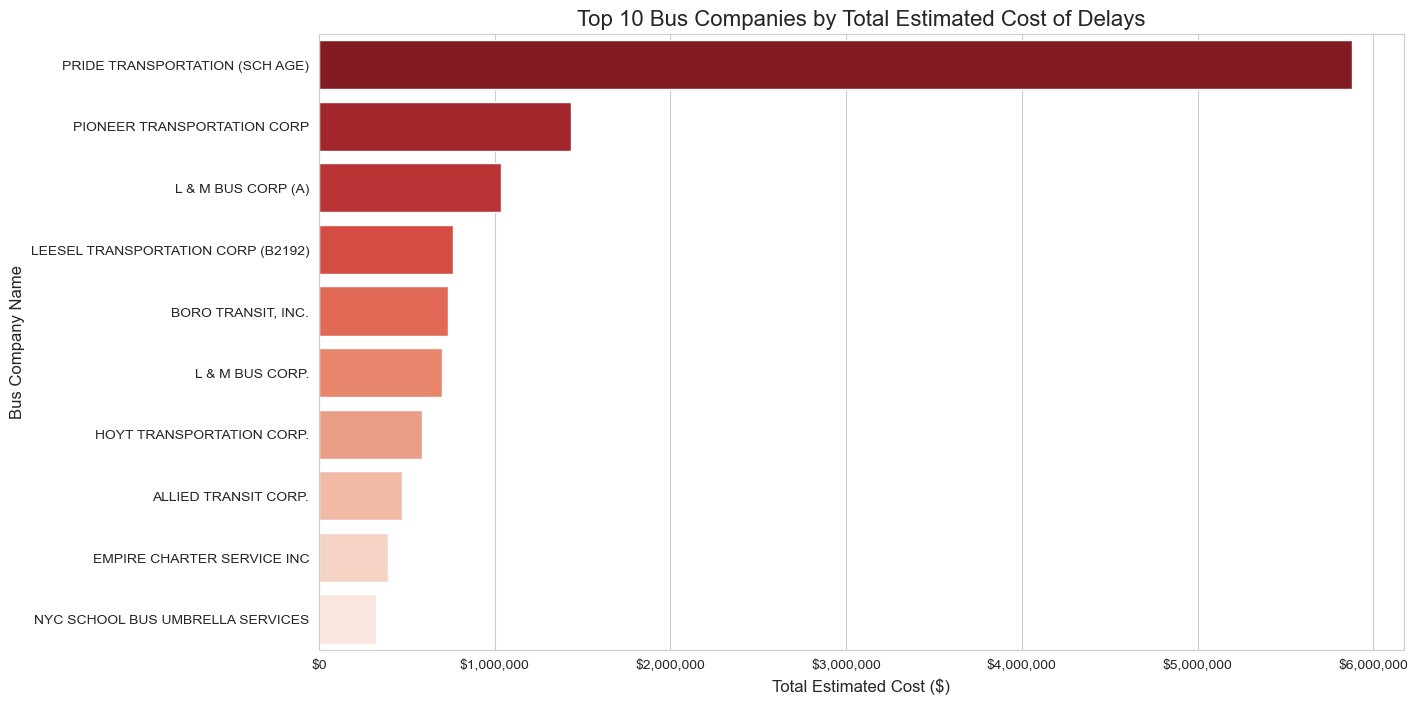

In [11]:
# Import necessary libraries if you haven't already
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Define Cost Assumptions ---
# These are hypothetical costs to demonstrate the method. In a real-world scenario,
# you would get these figures from the finance/operations department.
cost_assumptions = {
    'cost_per_minute_late': 2.50,  # Represents fuel, driver/staff overtime, etc.
    'parent_communication_cost': 5.00, # Fixed cost per incident for communication overhead
    'replacement_bus_dispatch': 500.00 # High cost for severe mechanical failures
}

# --- Step 2: Create a function to calculate the cost of each incident ---
def calculate_incident_cost(row):
    # Base cost is delay time + communication
    total_cost = (row['delay_minutes'] * cost_assumptions['cost_per_minute_late']) + \
                 cost_assumptions['parent_communication_cost']

    # Add a large fixed cost for severe mechanical breakdowns requiring a new bus
    if row['reason'] == 'Mechanical Problem' and row['delay_severity'] == 'Severe':
        total_cost += cost_assumptions['replacement_bus_dispatch']
    
    return total_cost

# --- Step 3: Apply the cost function to the entire dataset ---
# Ensure you are using your cleaned dataframe, named 'df'
df['estimated_cost'] = df.apply(calculate_incident_cost, axis=1)

print("Sample of Estimated Costs per Incident:")
print(df[['reason', 'delay_minutes', 'delay_severity', 'estimated_cost']].head())

# --- Step 4: Aggregate costs to find the most "expensive" companies ---
company_costs = df.groupby('bus_company_name')['estimated_cost'].sum().sort_values(ascending=False)

# --- Step 5: Visualize the financial impact ---
plt.figure(figsize=(14, 8))
top_10_costly_companies = company_costs.head(10)
sns.barplot(x=top_10_costly_companies.values, y=top_10_costly_companies.index, palette='Reds_r')
plt.title('Top 10 Bus Companies by Total Estimated Cost of Delays', fontsize=16)
plt.xlabel('Total Estimated Cost ($)', fontsize=12)
plt.ylabel('Bus Company Name', fontsize=12)
# Format the x-axis to look like currency
plt.gca().xaxis.set_major_formatter('${x:,.0f}')
plt.show()

In [12]:
# Select the top two most expensive companies from your analysis
top_company_name = 'PRIDE TRANSPORTATION (SCH AGE)'
second_company_name = 'PIONEER TRANSPORTATION CORP.'

# Filter the dataframe to only include these two companies
top_two_df = df[df['bus_company_name'].isin([top_company_name, second_company_name])]

# --- Perform a comparative analysis ---
print("--- Comparative Analysis ---")
# Group by company and get key metrics
comparison = top_two_df.groupby('bus_company_name').agg(
    total_incidents=('busbreakdown_id', 'count'),
    average_delay_minutes=('delay_minutes', 'mean'),
    total_estimated_cost=('estimated_cost', 'sum'),
    severe_mechanical_breakdowns=('reason', lambda x: (x == 'Mechanical Problem').sum())
).round(2)

print(comparison)

--- Comparative Analysis ---
                                total_incidents  average_delay_minutes  \
bus_company_name                                                         
PRIDE TRANSPORTATION (SCH AGE)            30555                  72.97   

                                total_estimated_cost  \
bus_company_name                                       
PRIDE TRANSPORTATION (SCH AGE)             5880547.5   

                                severe_mechanical_breakdowns  
bus_company_name                                              
PRIDE TRANSPORTATION (SCH AGE)                           322  
